<a href="https://colab.research.google.com/github/oreilly-japan/ml-at-work/blob/master/chap11/01_bandit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-947-2.gif)

이 노트북은 한빛미디어에서 발생한 [<<머신러닝 실무 프로젝트 2판>>]()의 샘플 코드입니다. 코드 설명은 책 내용을 확인합니다. 또한, 이 코드를 실행한 결과에 대해 한빛미디어 및 옮긴이는 일체의 책임을 지지 않습니다.

# 11장 슬롯머신 알고리즘을 이용한 강화학습 입문

In [1]:
# 나눔 폰트 설치. 설치후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (45.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and di

In [1]:
import math
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

## 11.2 확률 분포 사고 방식

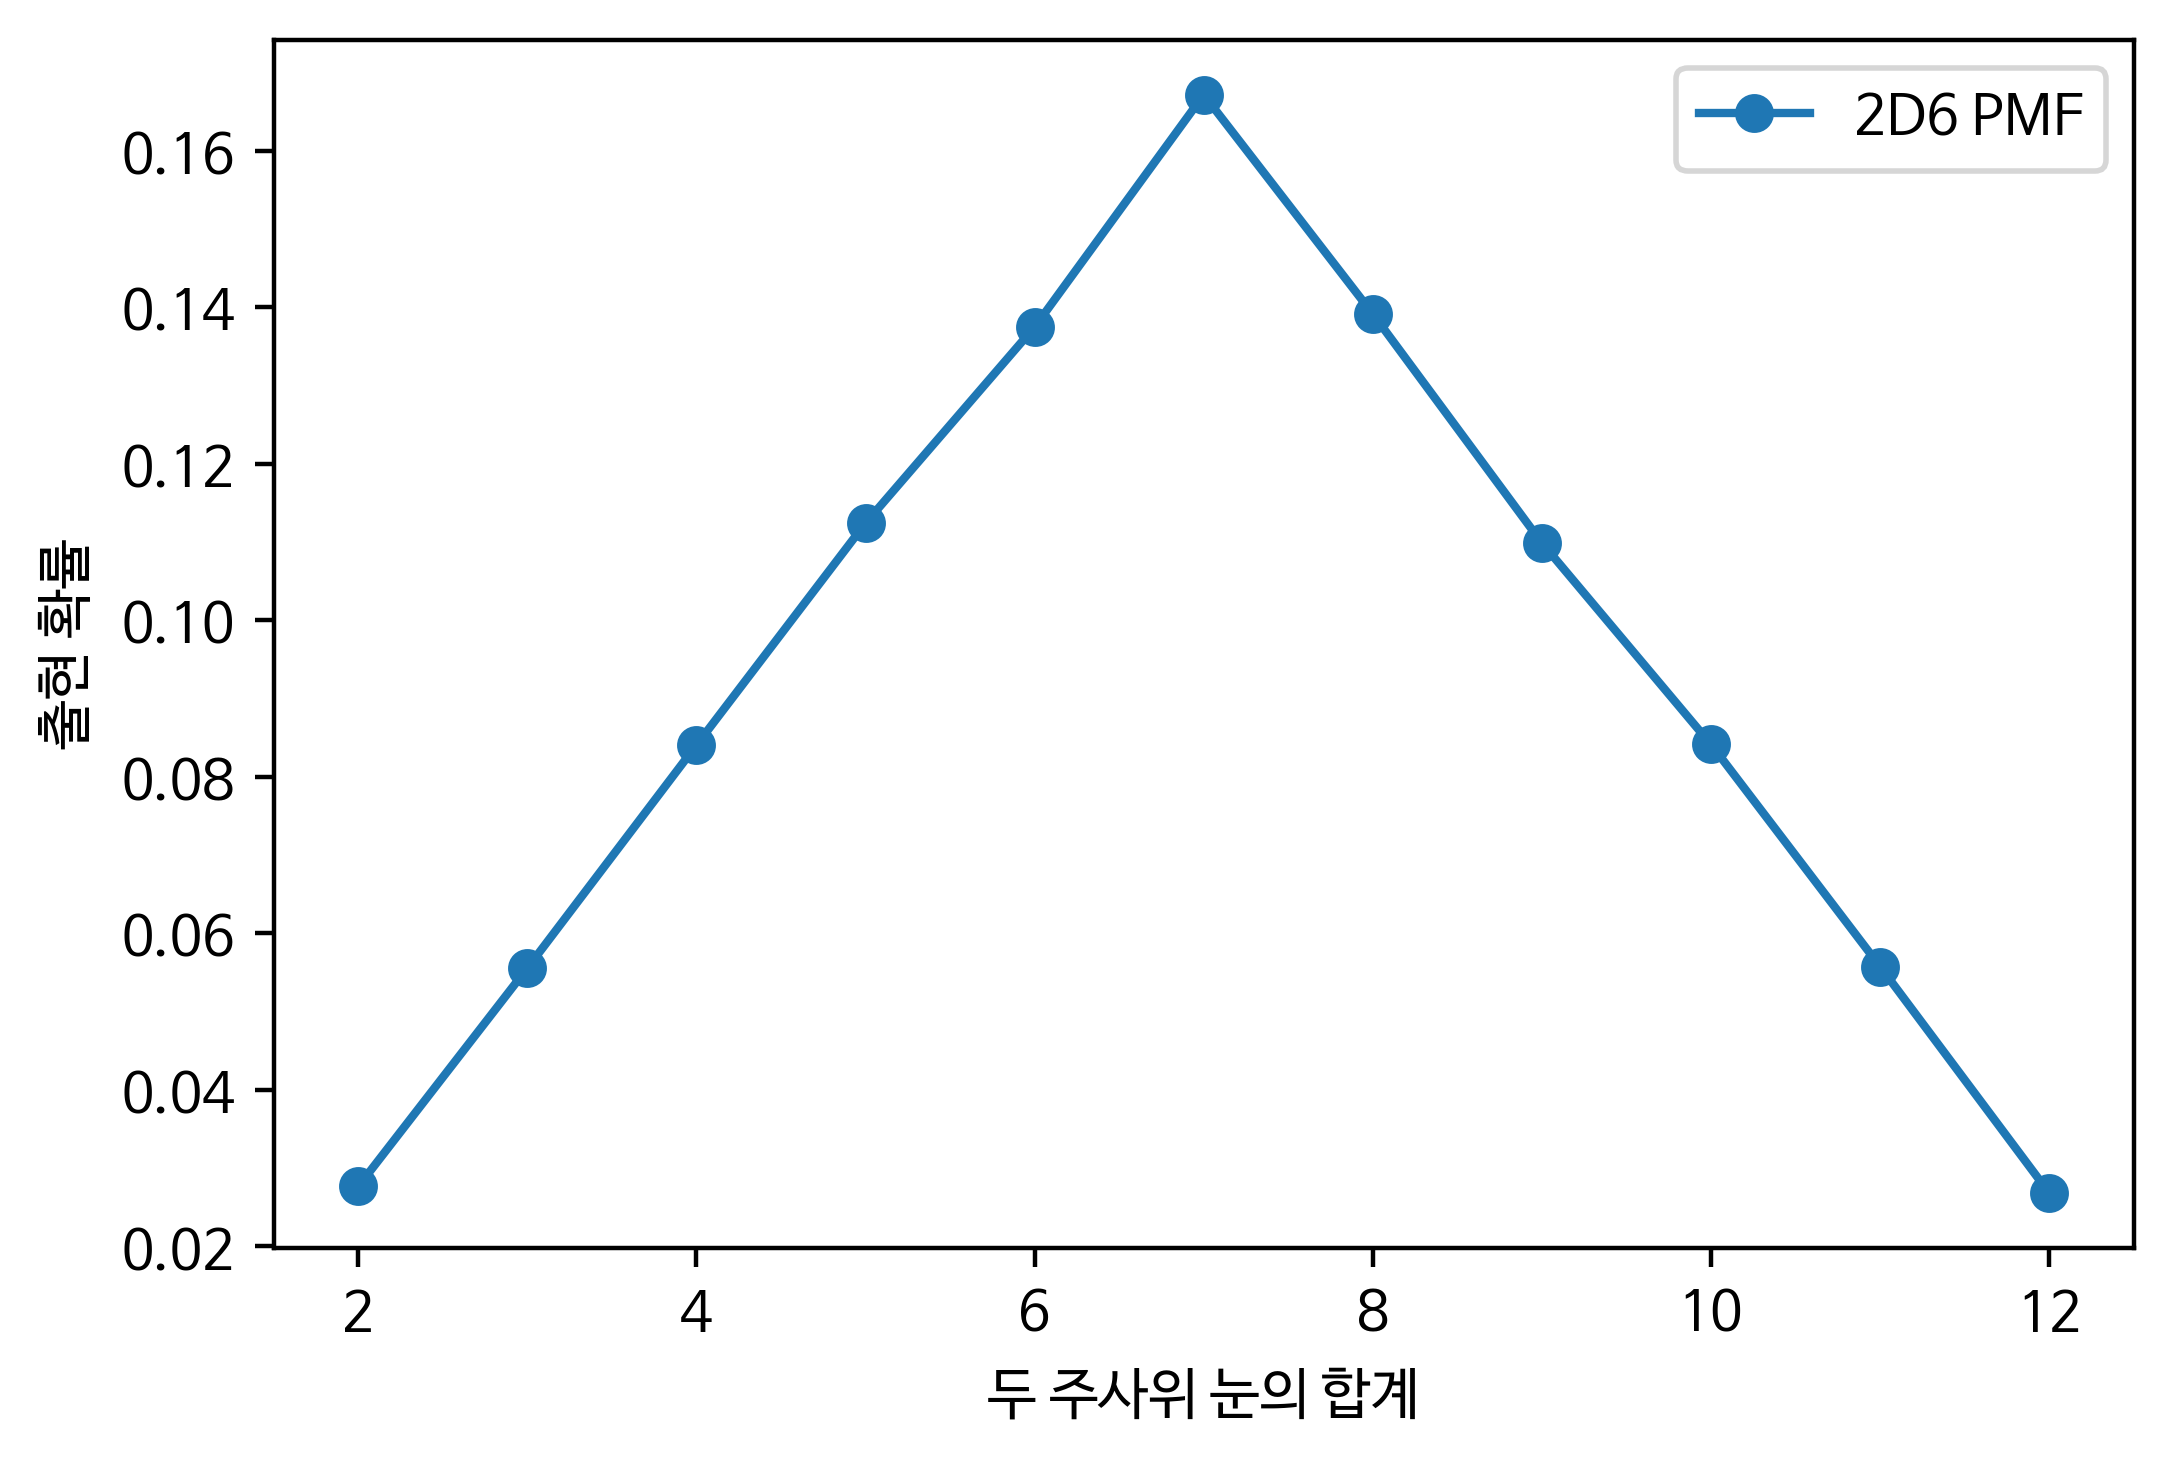

In [2]:
n = 100000
dice_total =  np.random.randint(1,7, size=n)
dice_total += np.random.randint(1,7, size=n)
x, y = np.unique(dice_total, return_counts=True)
y = y / n   # 카운트값을 출현 확률로 변환
plt.figure(dpi=400)
plt.plot(x, y, marker="o", label="2D6 PMF")
plt.legend()
plt.xlabel("두 주사위 눈의 합계")
plt.ylabel("출현 확률")
plt.show()

[0.02767 0.08323 0.16728 0.27969 0.41715 0.58427 0.7234  0.83327 0.91741
 0.97317 1.     ]


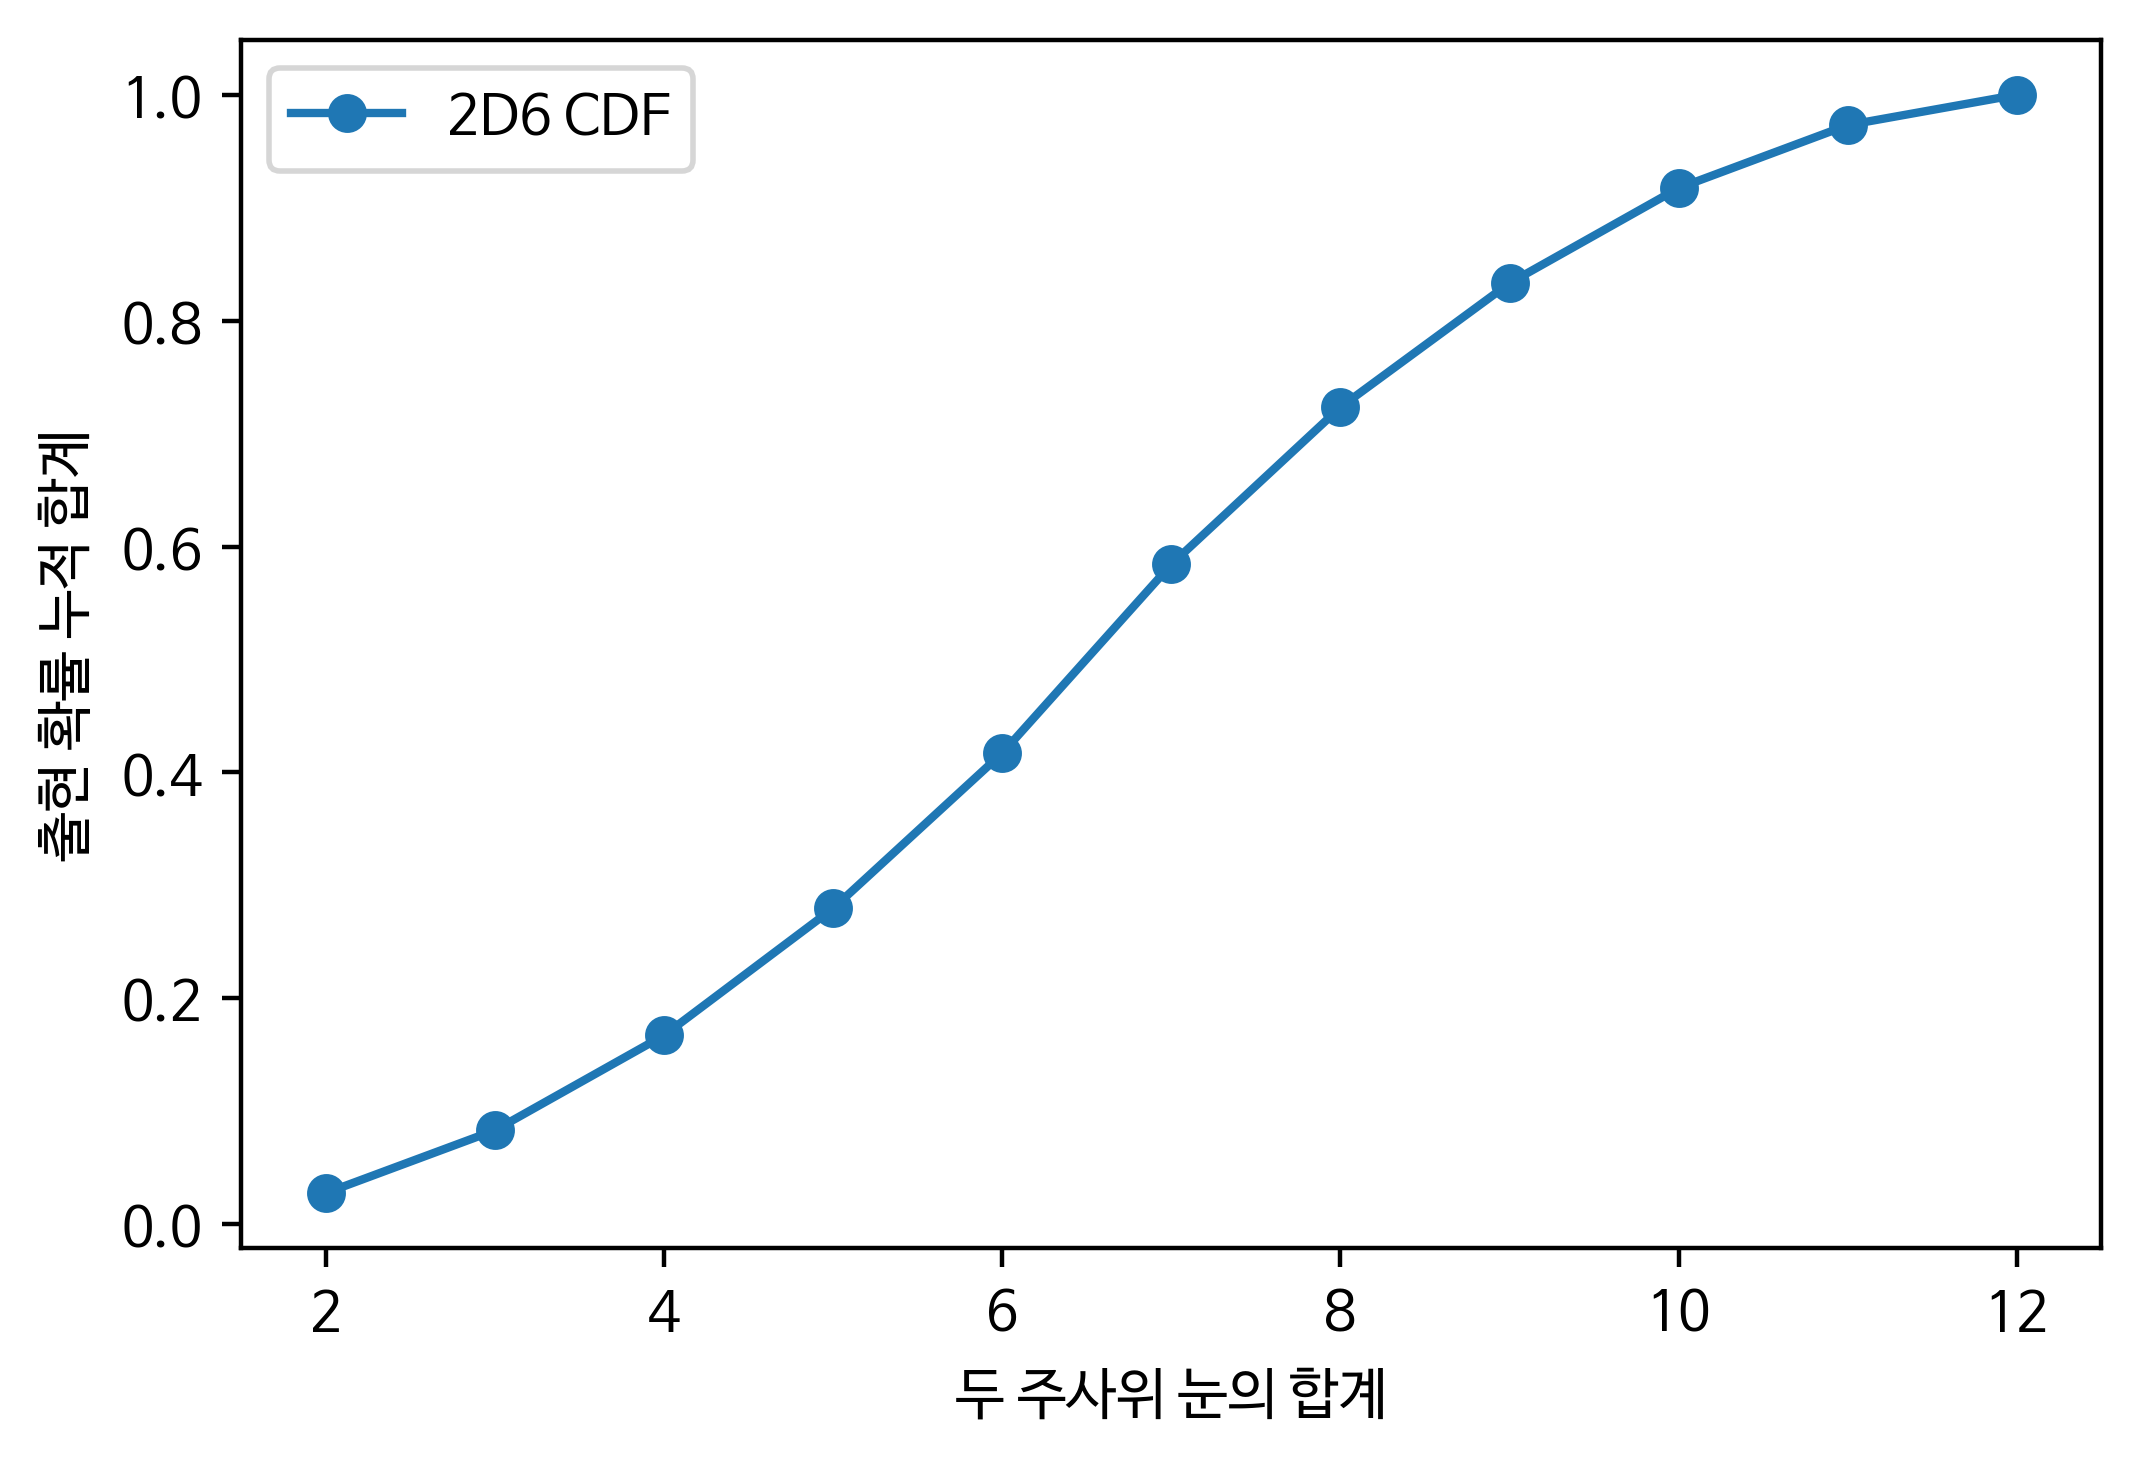

In [3]:
cumsum_y = np.cumsum(y)
print(cumsum_y)
plt.figure(dpi=400)
plt.plot(x, cumsum_y, marker="o", label="2D6 CDF")
plt.legend()
plt.xlabel("두 주사위 눈의 합계")
plt.ylabel("출현 확률 누적 합계")
plt.show()

## 11.3 사후 분포 사고 방식

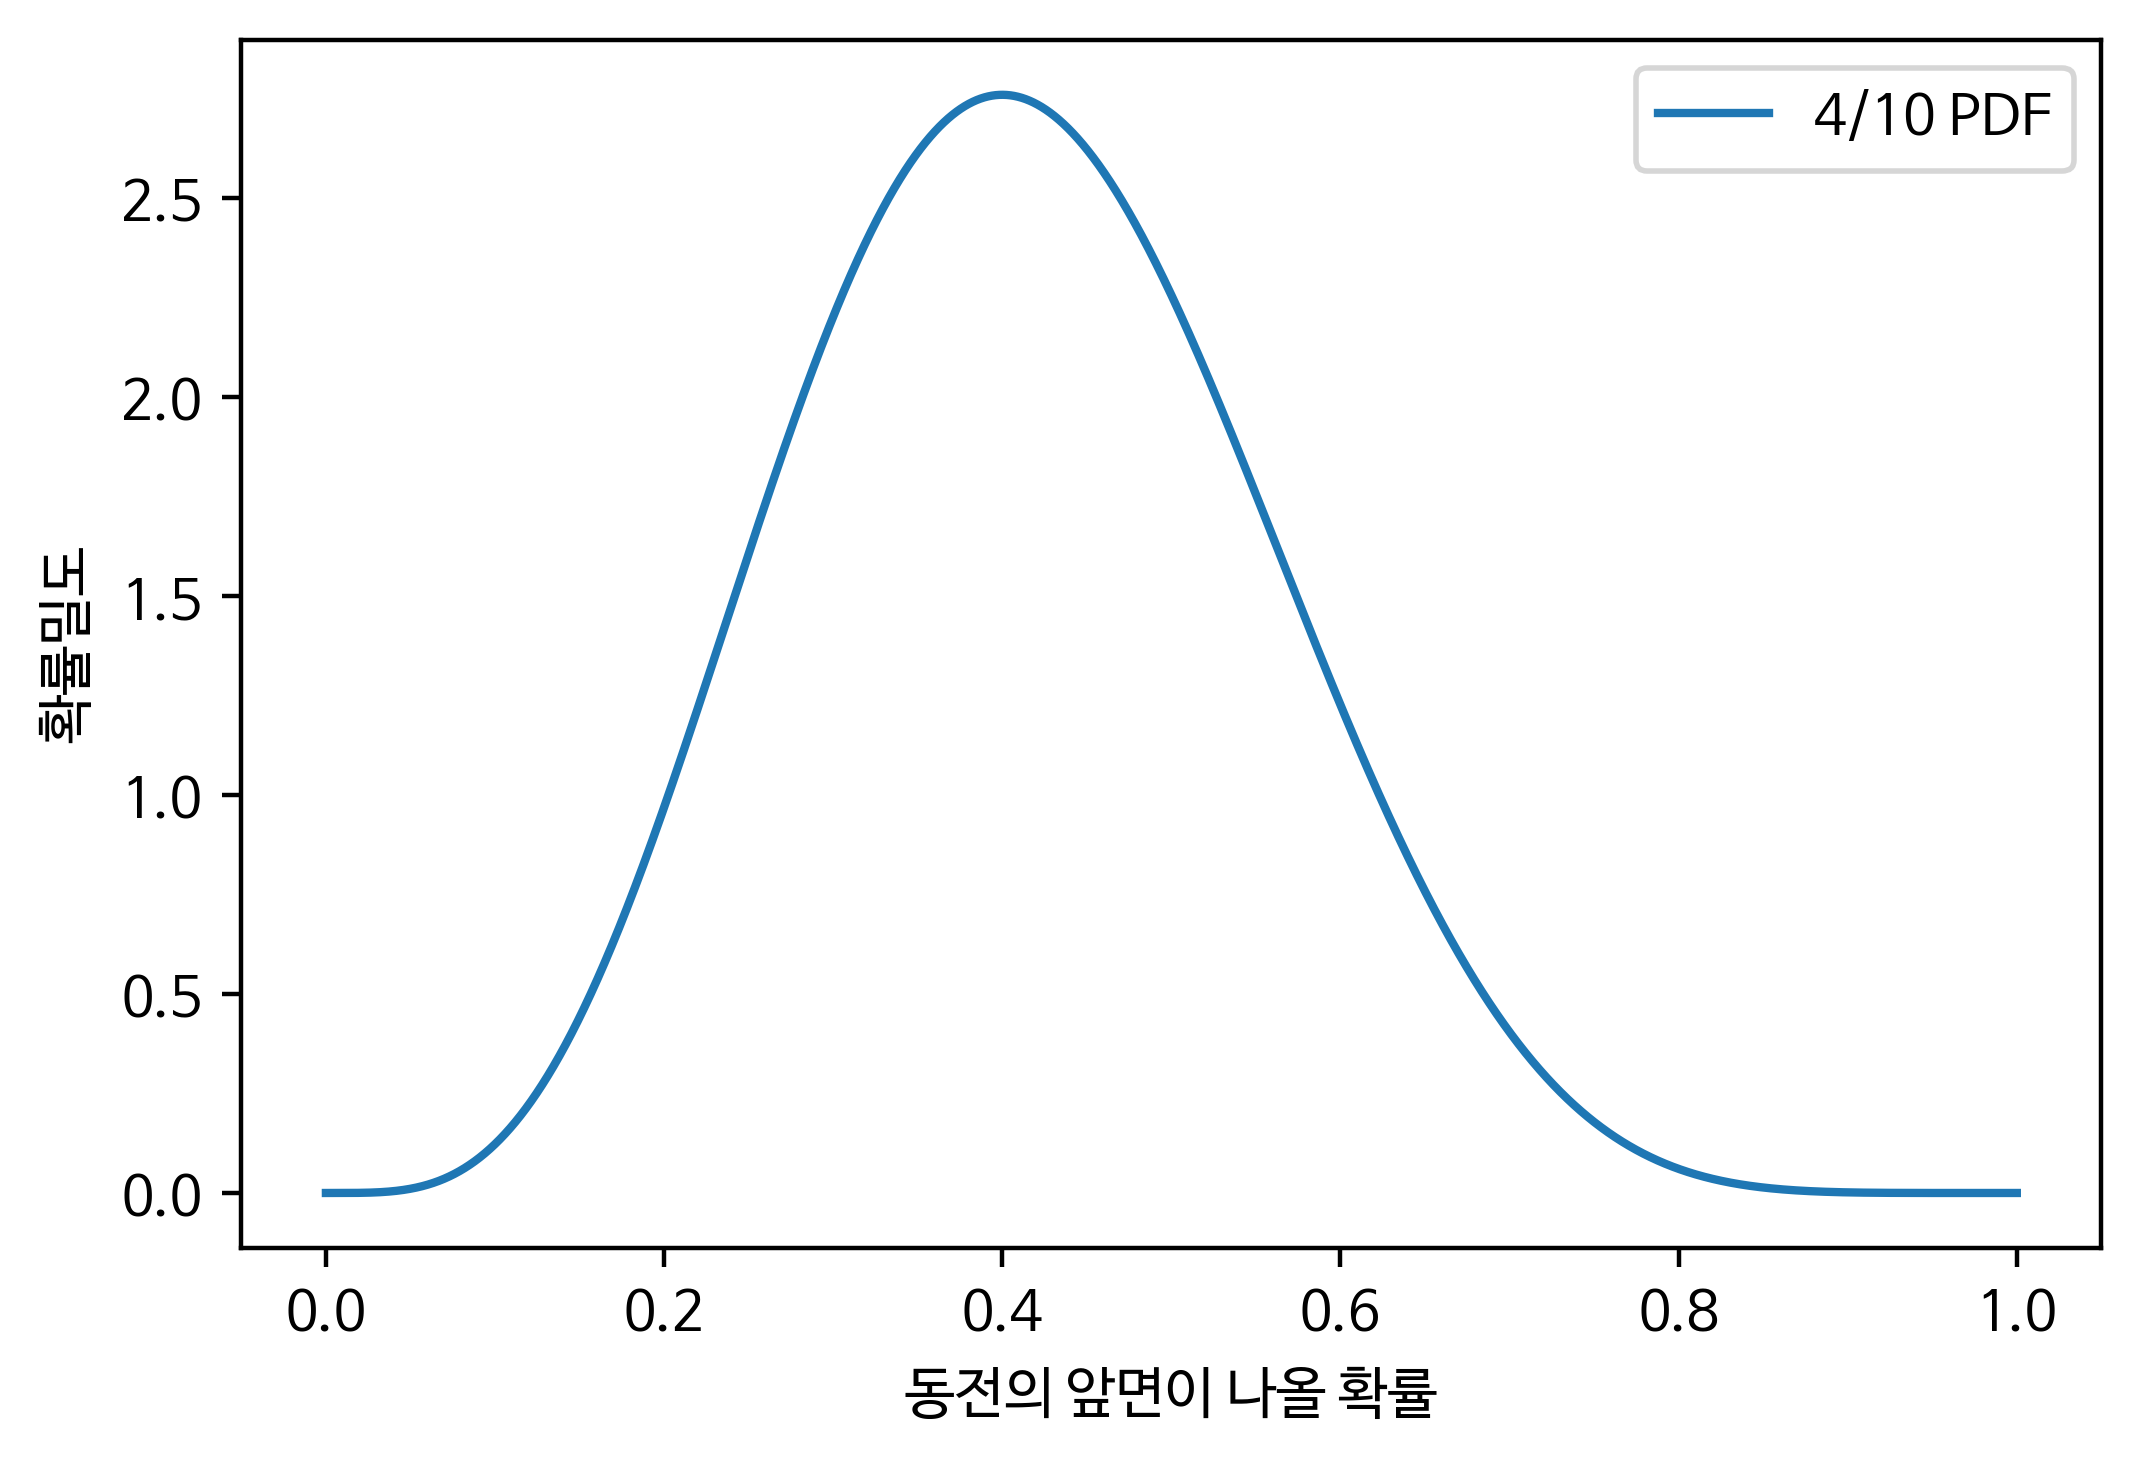

In [4]:
a = 4       # 앞면이 나온 횟수
b = 10 - a  # 뒷면이 나온 횟수

x = np.linspace(0, 1, 10000)
plt.figure(dpi=400)
plt.plot(x, scipy.stats.beta.pdf(x, a+1, b+1), label="4/10 PDF")
plt.legend()
plt.xlabel("동전의 앞면이 나올 확률")
plt.ylabel("확률밀도")
plt.show()

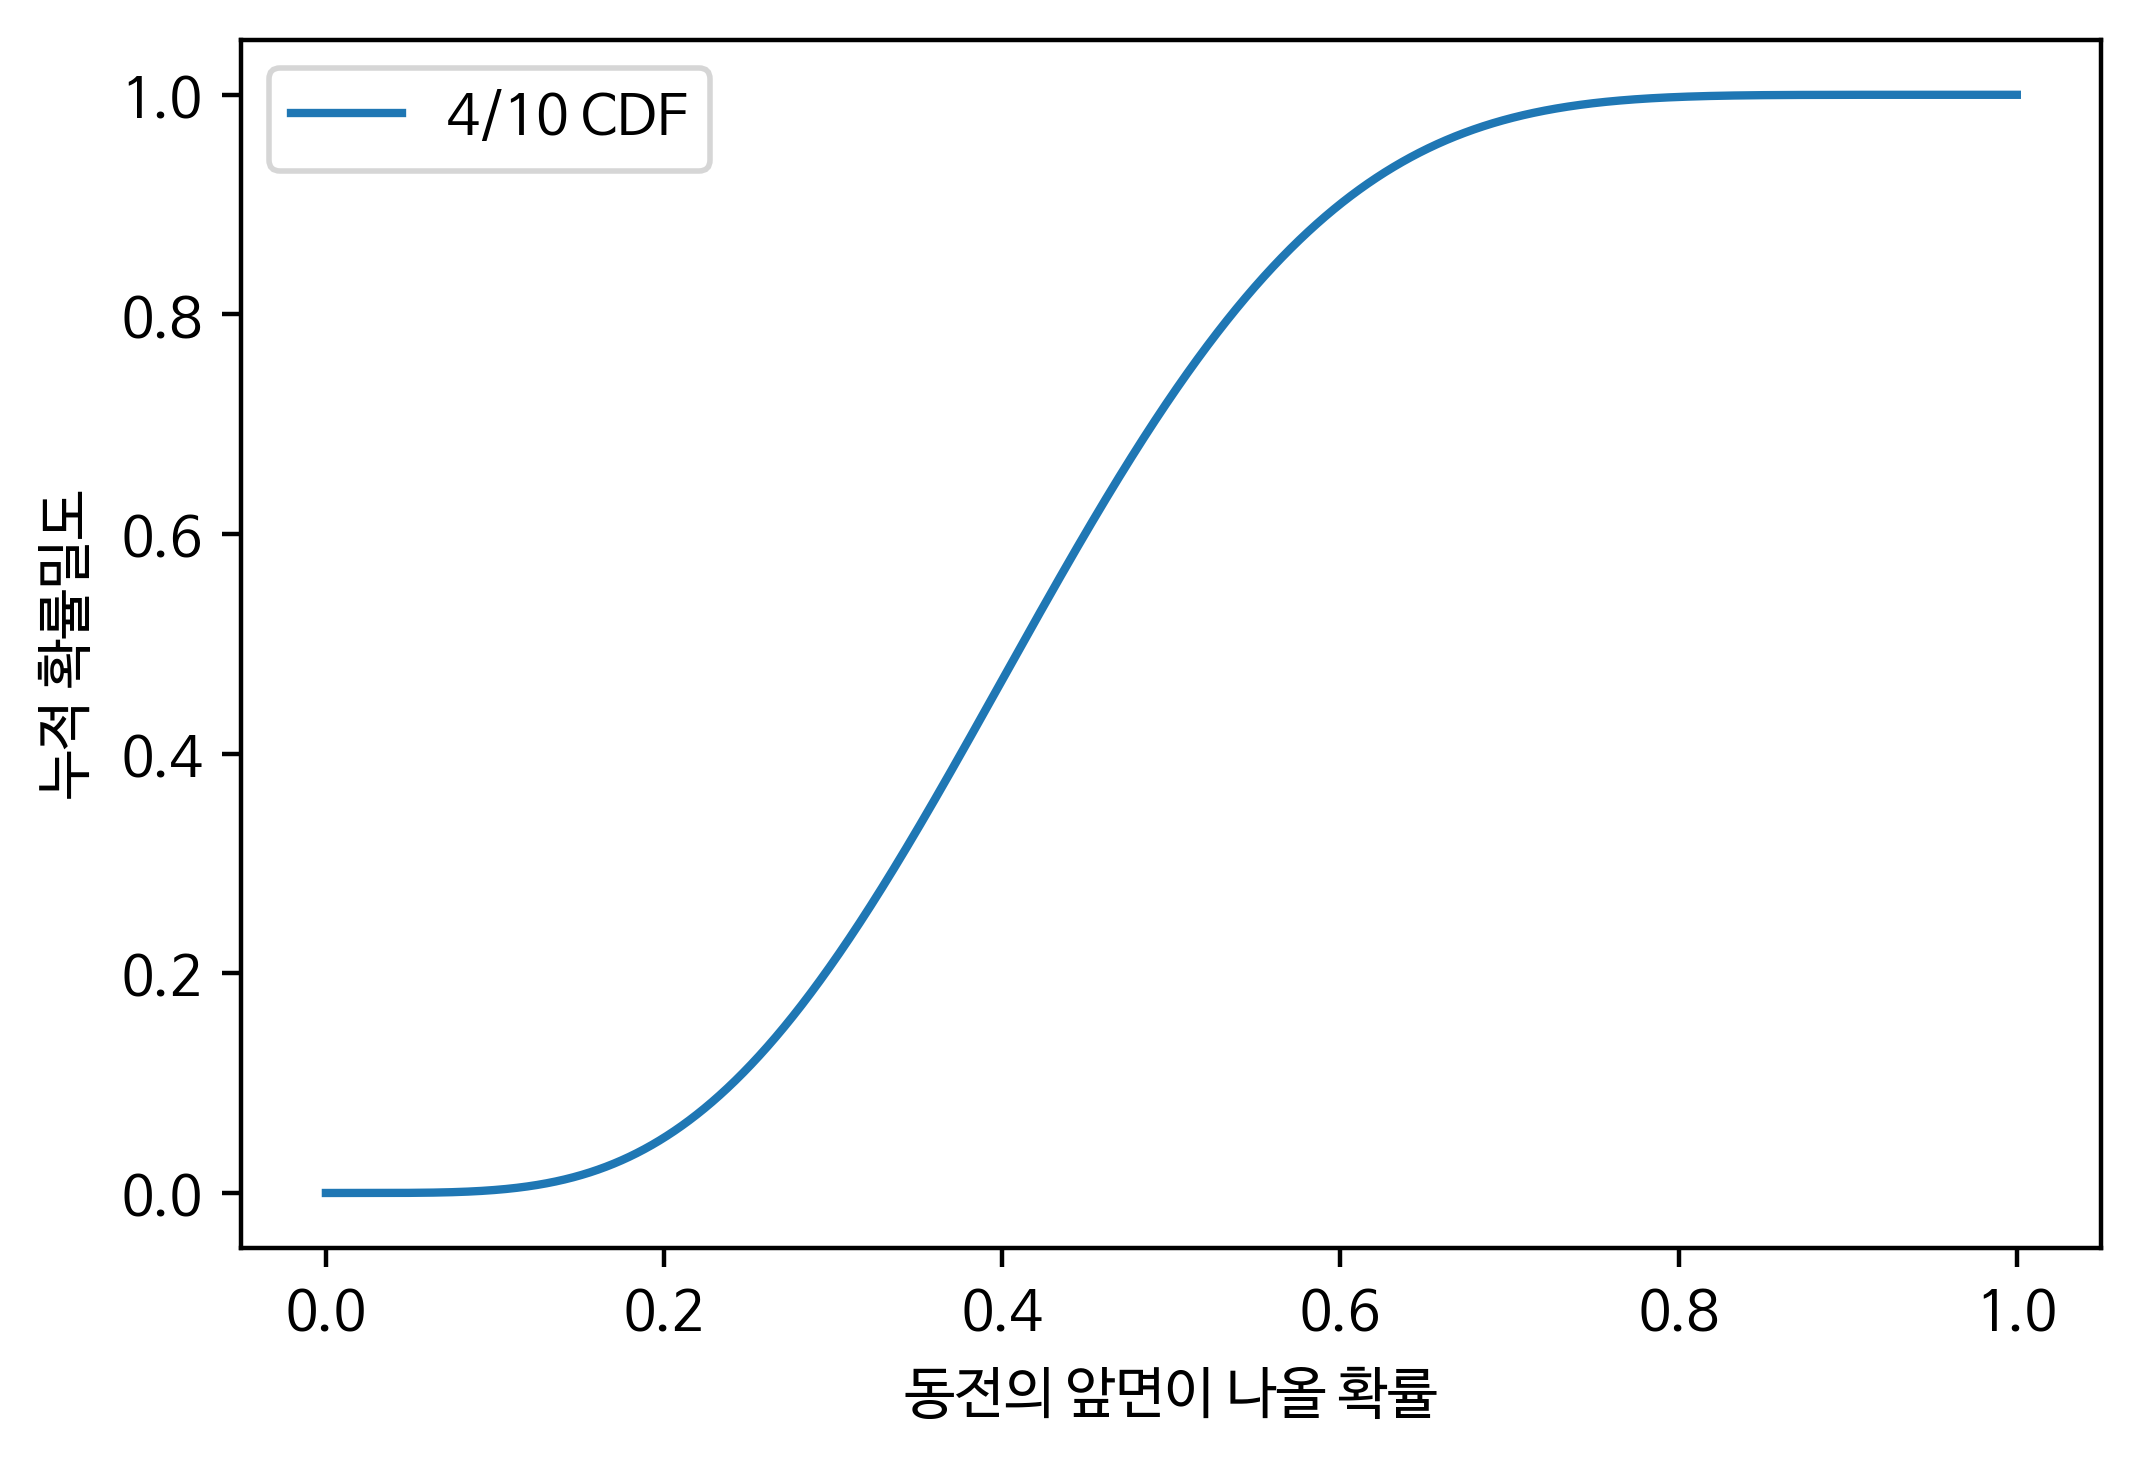

In [5]:
plt.figure(dpi=400)
plt.plot(x, scipy.stats.beta.cdf(x, a+1, b+1), label="4/10 CDF")
plt.legend()
plt.xlabel("동전의 앞면이 나올 확률")
plt.ylabel("누적 확률밀도")
plt.show()

In [6]:
print(" 5%", scipy.stats.beta.ppf(0.05, a + 1, b + 1))
print("95%", scipy.stats.beta.ppf(0.95, a + 1, b + 1))
print("90% 신뢰 구간", scipy.stats.beta.interval(0.90, a + 1, b + 1))

 5% 0.19957614988383673
95% 0.6501884654280826
90% 신뢰 구간 (0.1995761498838367, 0.6501884654280826)


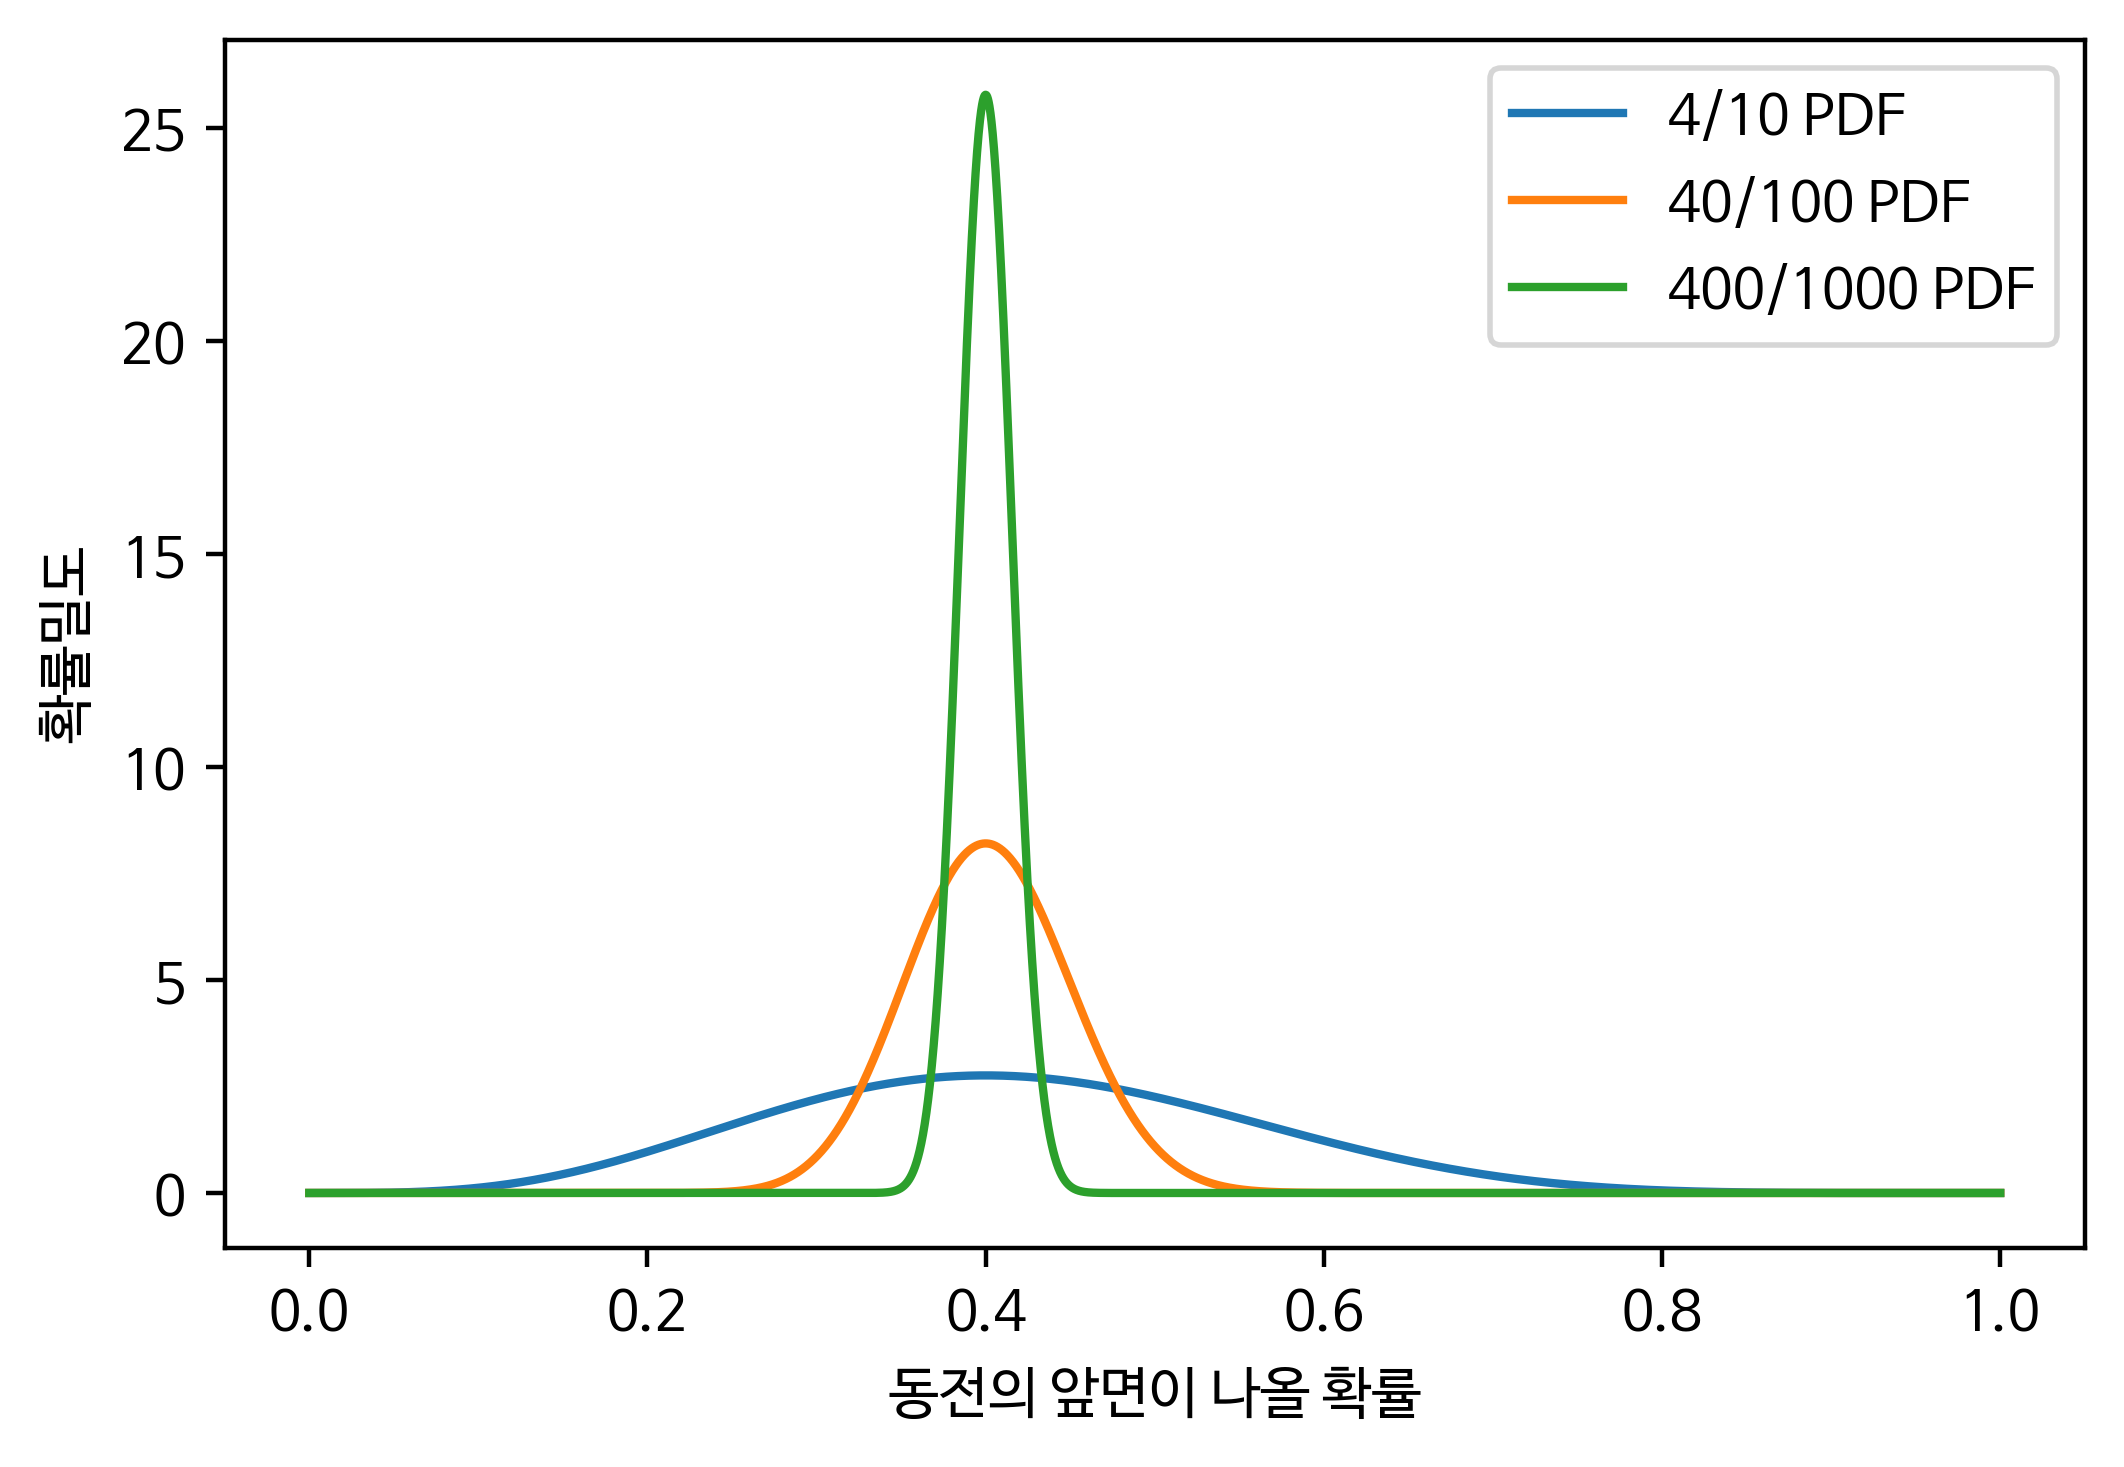

In [7]:
a1 = 4
b1 = 10 - a1
a2 = 40
b2 = 100 - a2
a3 = 400
b3 = 1000 - a3
x = np.linspace(0, 1, 10000)
plt.figure(dpi=400)
plt.plot(x, scipy.stats.beta.pdf(x, a1 + 1, b1 + 1), label="4/10 PDF")
plt.plot(x, scipy.stats.beta.pdf(x, a2 + 1, b2 + 1), label="40/100 PDF")
plt.plot(x, scipy.stats.beta.pdf(x, a3 + 1, b3 + 1), label="400/1000 PDF")
plt.legend()
plt.xlabel("동전의 앞면이 나올 확률")
plt.ylabel("확률밀도")
plt.show()

In [8]:
print("90% 신뢰구간(  4/  10)\t", scipy.stats.beta.interval(0.90, a1 + 1, b1 + 1))
print("90% 신뢰구간( 40/ 100)\t", scipy.stats.beta.interval(0.90, a2 + 1, b2 + 1))
print("90% 신뢰구간(400/1000)\t", scipy.stats.beta.interval(0.90, a3 + 1, b3 + 1))

90% 신뢰구간(  4/  10)	 (0.1995761498838367, 0.6501884654280826)
90% 신뢰구간( 40/ 100)	 (0.32355743256469754, 0.48256117185206715)
90% 신뢰구간(400/1000)	 (0.37486561630199944, 0.42576020414058036)


## 11.4 사후 분포의 신뢰구간 상한을 이용한 구현 예

[]

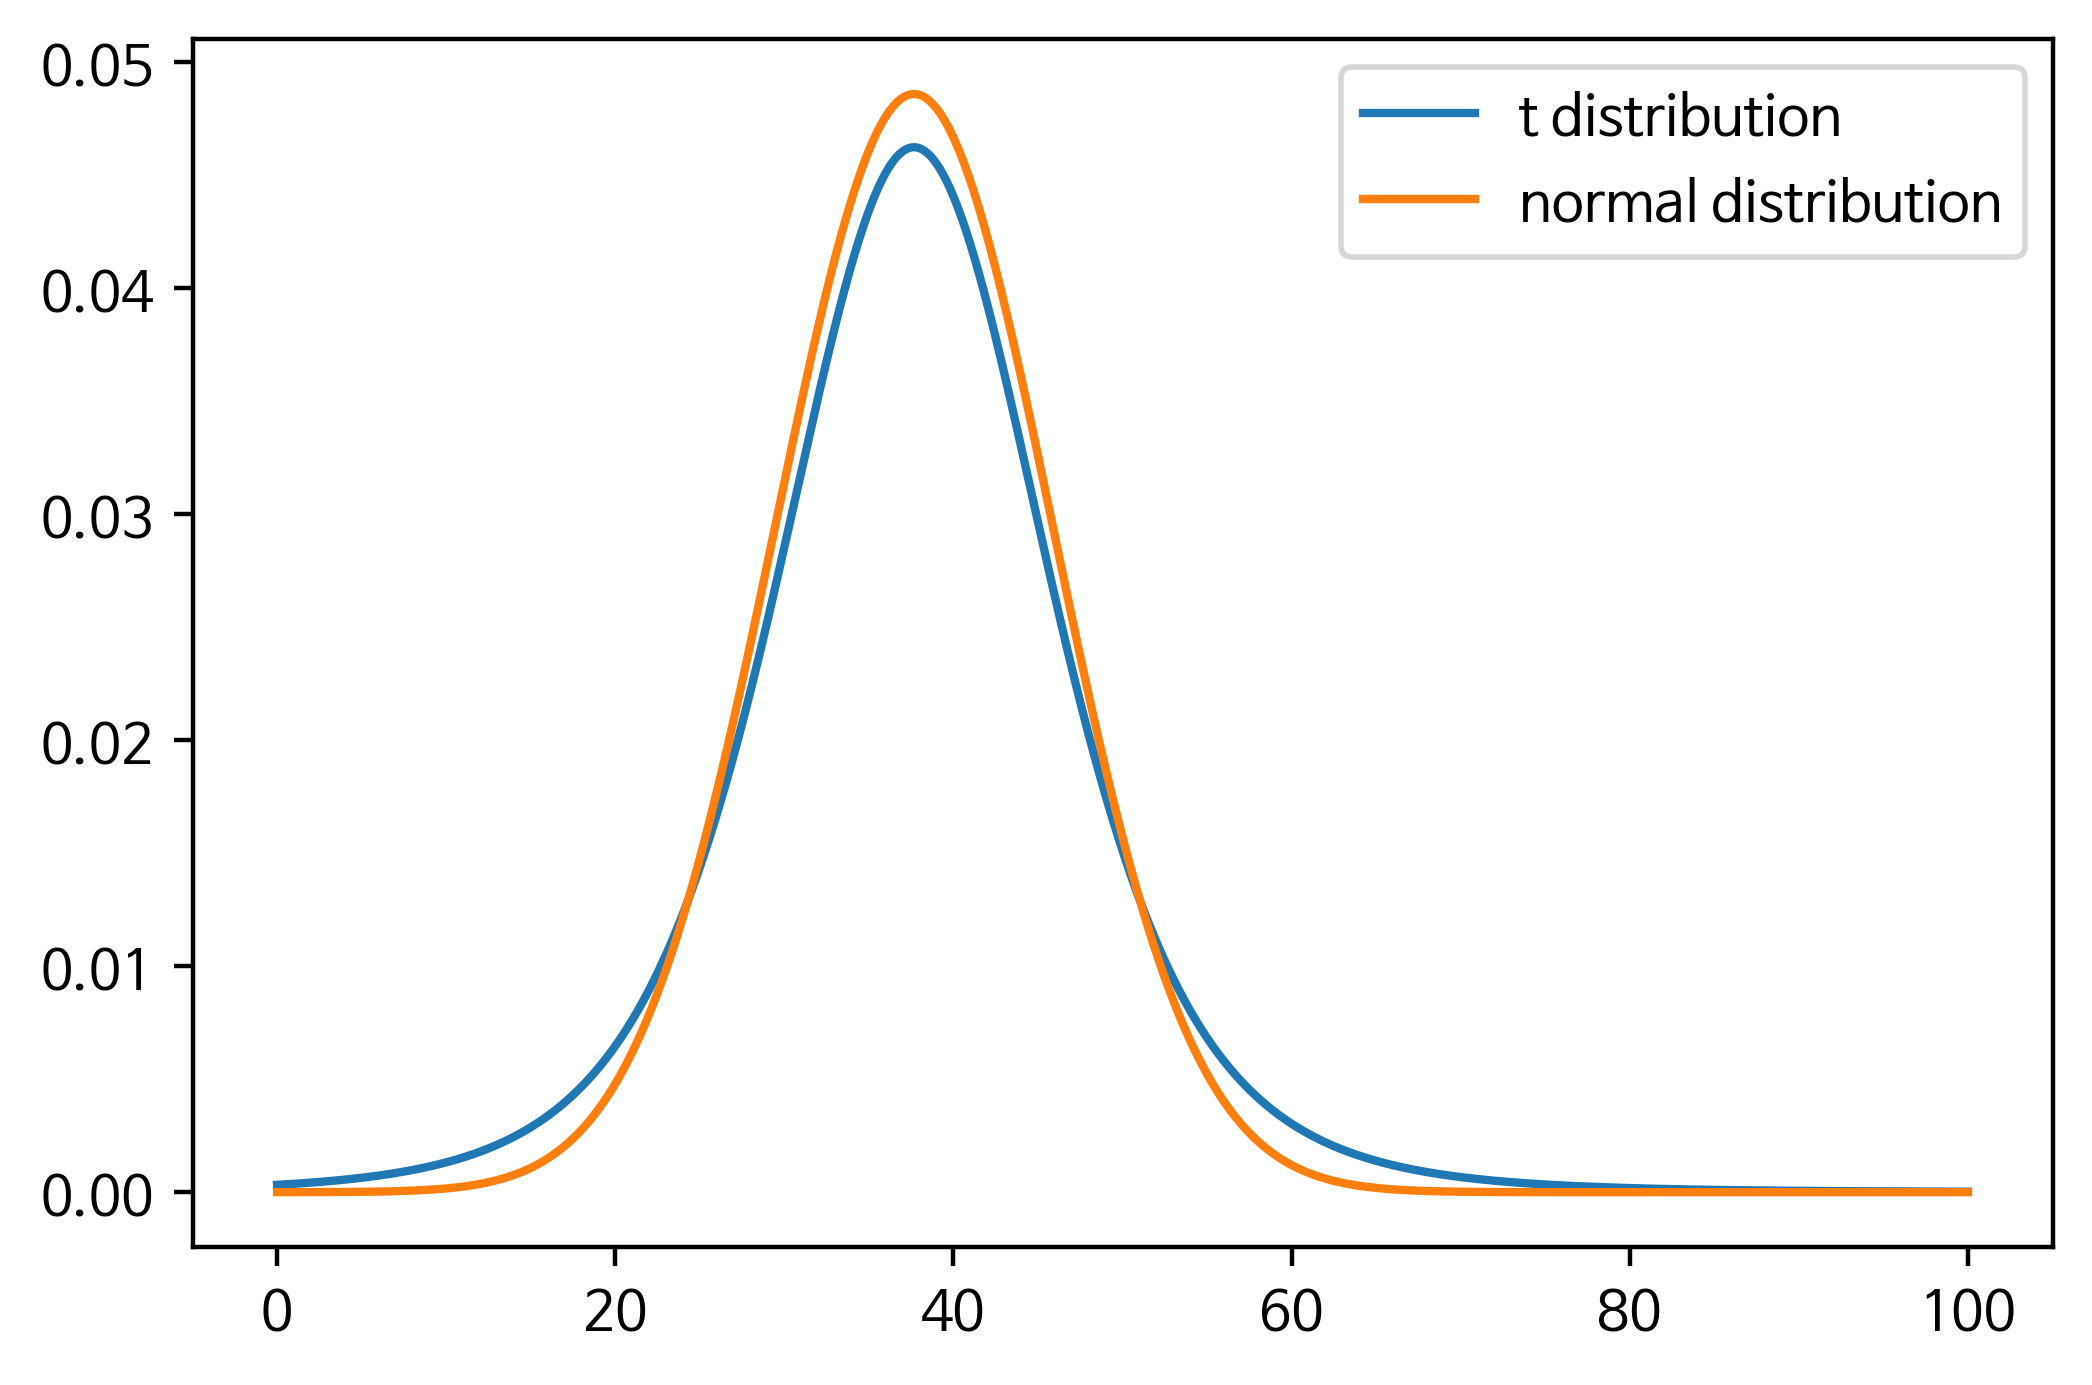

In [9]:
# https://hira03.hatenablog.com/entry/statistics_interval_estimation_of_population_mean_unknown (일본어)

data = [32, 12, 20, 42, 61, 59]  # 표본
n = len(data)  # 표본 크기
mean = np.mean(data)  # 표본 평균
se = np.std(data, ddof=1) / (n ** 0.5)  # 표본 오차
dof = n - 1  # 자유도
x = np.linspace(0, 100, 10000)
plt.figure(dpi=400)
plt.plot(x, scipy.stats.t.pdf(x, loc=mean, scale=se, df=dof), label="t distribution")
plt.plot(x, scipy.stats.norm.pdf(x, loc=mean, scale=se), label="normal distribution")
plt.legend()
plt.plot()

Text(0, 0.5, '확률밀도')

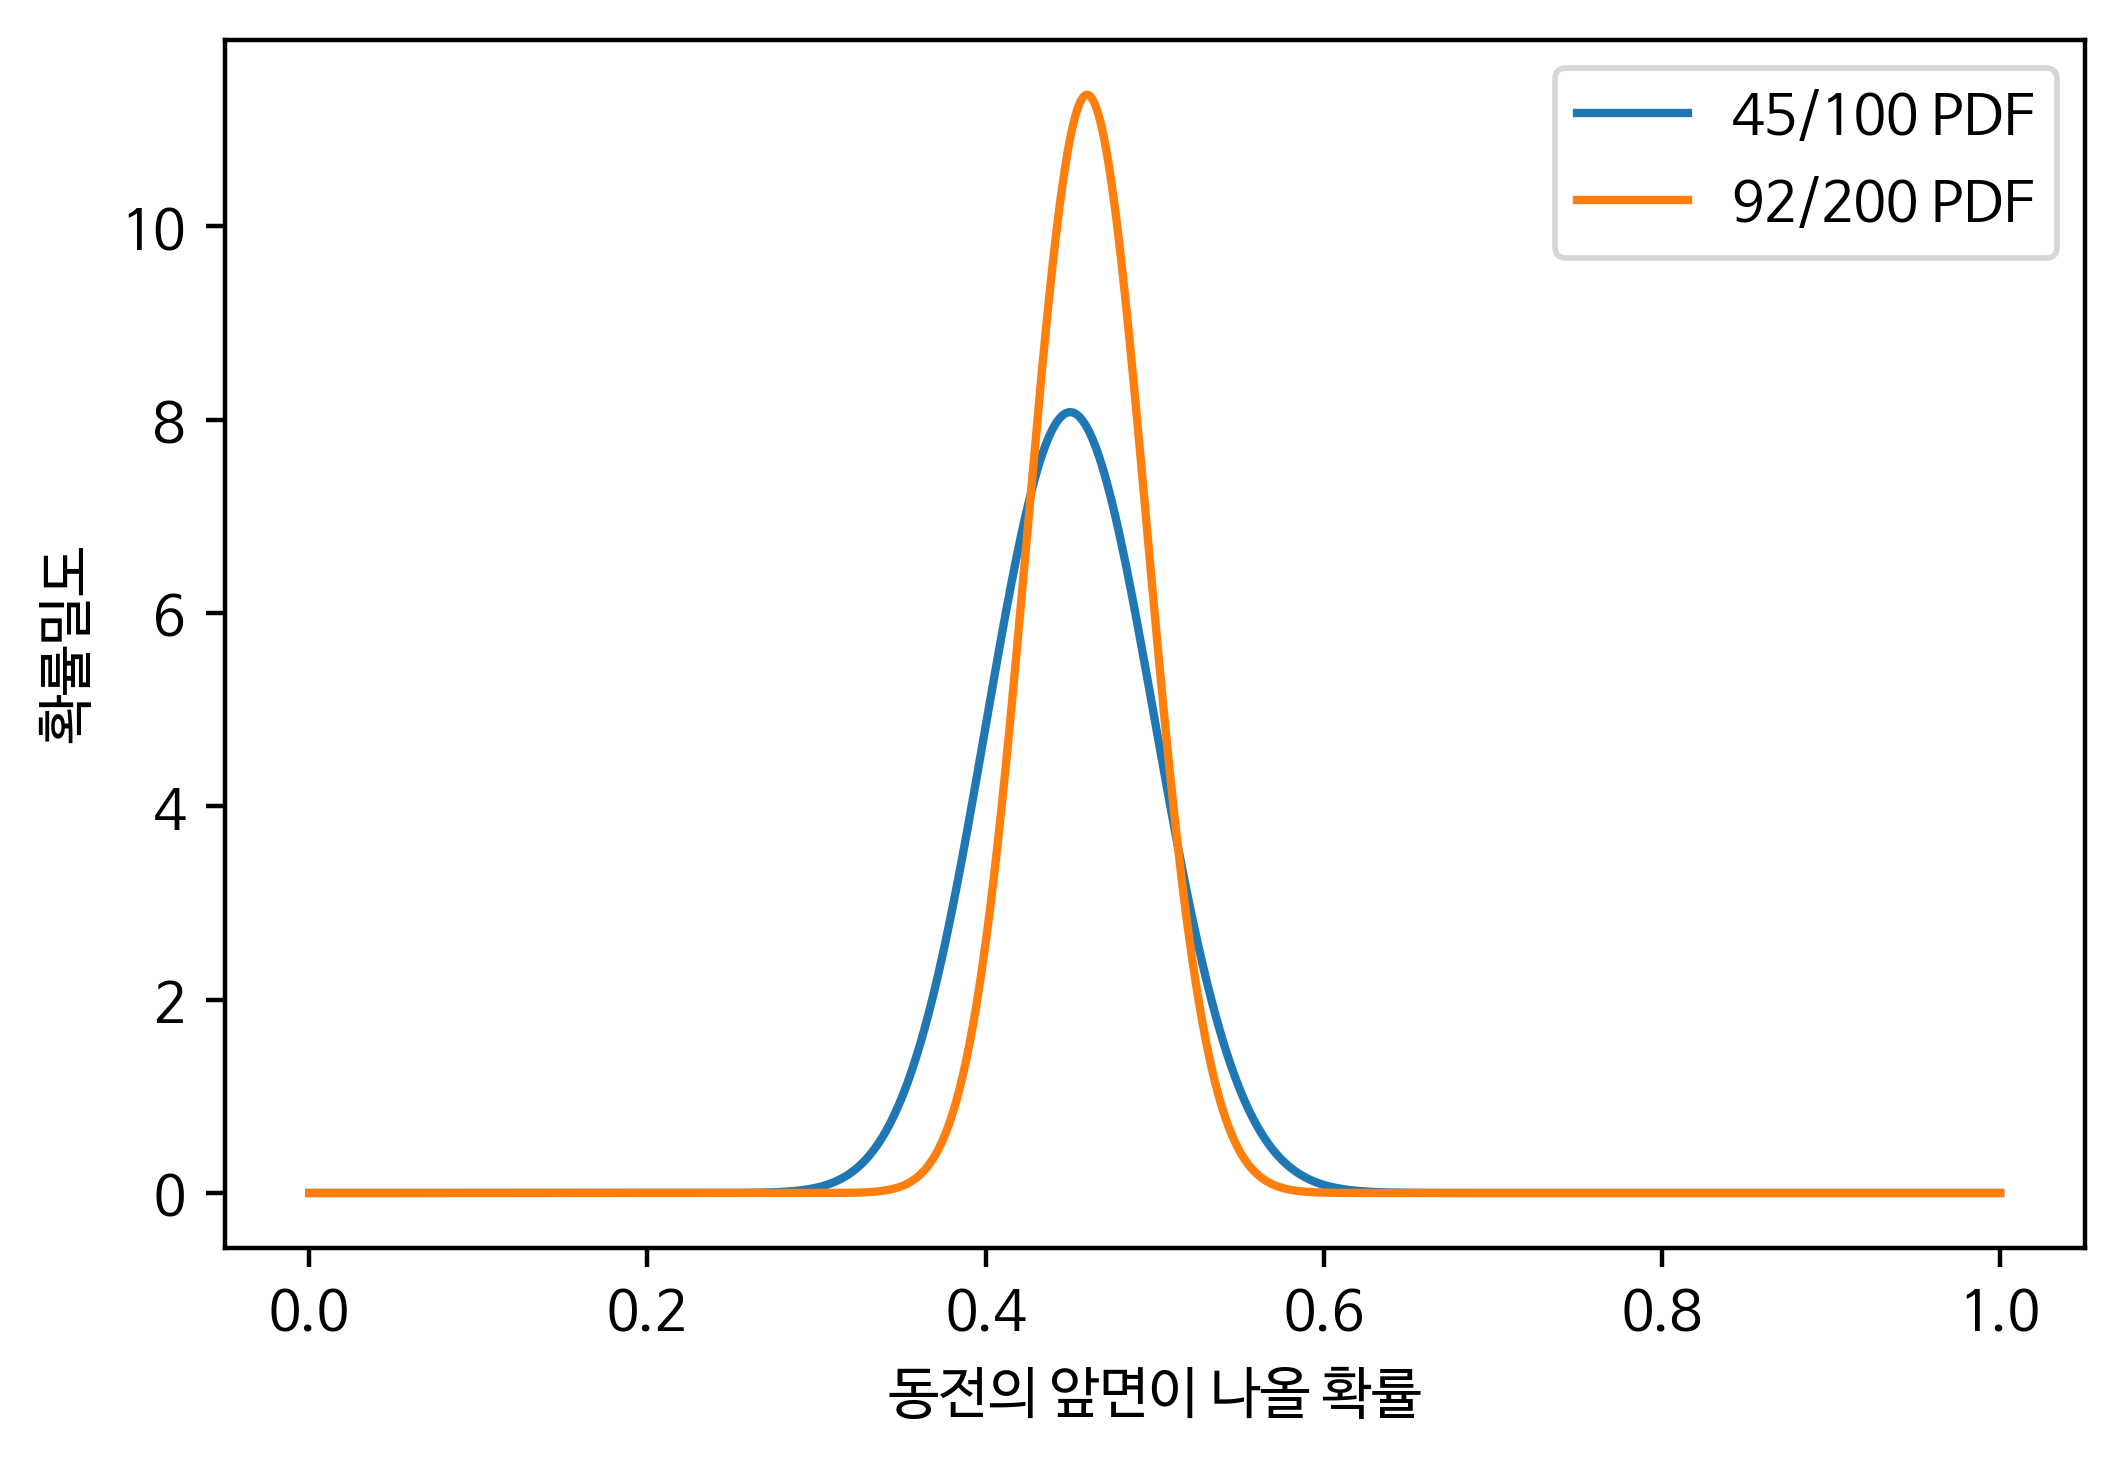

In [10]:
a1 = 45
b1 = 100 - a1
a2 = 92
b2 = 200 - a2
x = np.linspace(0, 1, 10000)
plt.figure(dpi=400)
plt.plot(x, scipy.stats.beta.pdf(x, a1+1, b1+1), label="45/100 PDF")
plt.plot(x, scipy.stats.beta.pdf(x, a2+1, b2+1), label="92/200 PDF")
plt.legend()
plt.xlabel("동전의 앞면이 나올 확률")
plt.ylabel("확률밀도")

In [11]:
print("CoinA:", scipy.stats.beta.ppf(0.95, a1 + 1, b1 + 1))
print("CoinB:", scipy.stats.beta.ppf(0.95, a2 + 1, b2 + 1))


CoinA: 0.5322261940040164
CoinB: 0.5181806676164464


In [12]:
np.argmax(scipy.stats.beta.ppf(0.95, [a1 + 1, a2 + 1], [b1 + 1, b2 + 1]))

0

## 11.5 UCB1

In [13]:
a1 = 45
b1 = 100 - a1
a2 = 92
b2 = 200 - a2

print("CoinA:", a1/(a1+b1) + (2 * np.log(a1+b1+a2+b2) / (a1+b1)) ** 0.5)
print("CoinB:", a2/(a2+b2) + (2 * np.log(a1+b1+a2+b2) / (a2+b2)) ** 0.5)

CoinA: 0.7877508689746393
CoinB: 0.6988259298036166


## 11.6.1 Softmax 알고리즘

In [14]:
def softmax(x, t):
    return np.exp(x / t)/ np.sum(np.exp(x / t))

conversion_rate = np.array([0.12, 0.11, 0.10])
select_rate = softmax(conversion_rate, 0.01)
print(select_rate)

[0.66524096 0.24472847 0.09003057]


In [15]:
np.random.choice(len(select_rate), size=20, p=select_rate)

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2])

In [16]:
select_rate = softmax(conversion_rate, 100)
print(select_rate)

[0.33336667 0.33333333 0.3333    ]


## 11.6.2 톰슨 샘플링 알고리즘

In [17]:
a = 40
b = 100 - a
print(scipy.stats.beta.rvs(a + 1, b + 1, size=3))
print(np.random.beta(a + 1, b + 1, size=3))

[0.49052968 0.38647486 0.43170145]
[0.35311304 0.4056786  0.38067632]


In [18]:
a1 = 45
b1 = 100 - a1
a2 = 92
b2 = 200 - a2
coin_a_dist = scipy.stats.beta.rvs(a1 + 1, b1 + 1, size=3)
coin_b_dist = scipy.stats.beta.rvs(a2 + 1, b2 + 1, size=3)
print("CoinA:", coin_a_dist)
print("CoinB:", coin_b_dist)
print("CoinA>CoinB", coin_a_dist > coin_b_dist)

CoinA: [0.46188098 0.40791905 0.43938709]
CoinB: [0.48141821 0.50646633 0.47445637]
CoinA>CoinB [False False False]


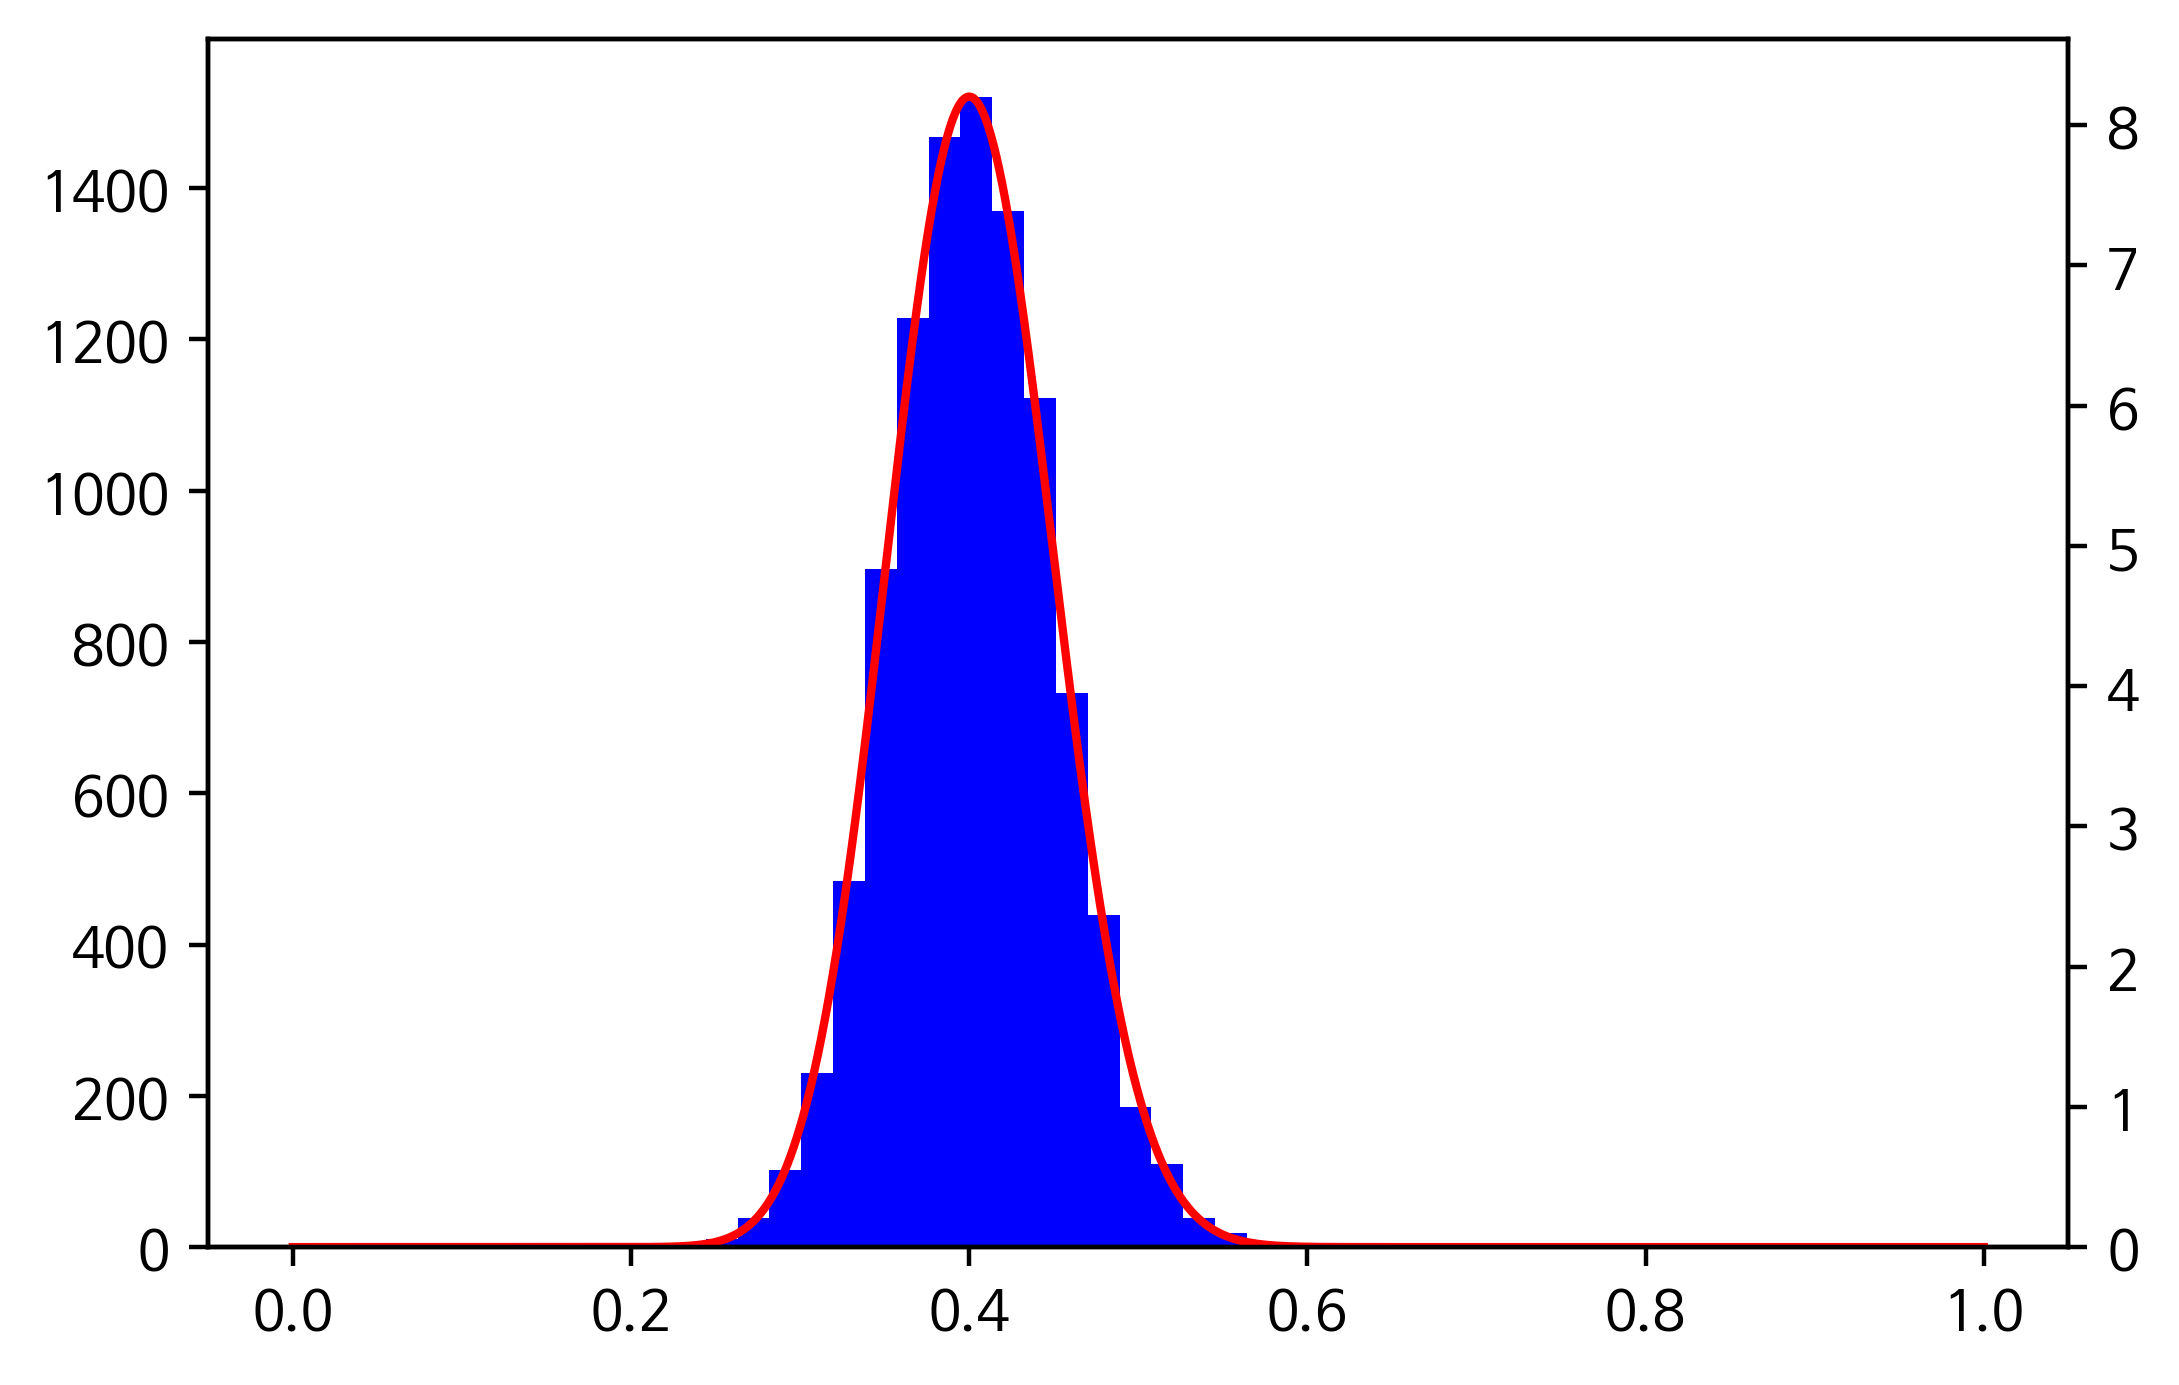

In [19]:
a = 40
b = 100 - a
x = np.linspace(0, 1, 10000)

fig, ax1 = plt.subplots(dpi=400)
ax2 = ax1.twinx()

# btea 분포에서 난수를 10,000개 생성해 히스토그램으로 나타냄
ax1.hist(scipy.stats.beta.rvs(a + 1, b + 1, size=10000), bins=20, color="blue", label="beta histgram")

# beta 분포의 확률밀도 함수를 나타냄
ax2.plot(x, scipy.stats.beta.pdf(x, a + 1, b + 1), color="red", label="beta PDF")
ax2.set_ylim(0,)

plt.show()

In [20]:
a1 = 45
b1 = 100 - a1
a2 = 92
b2 = 200 - a2
n = 10000
thompson_sampling_score = np.random.beta([a1 + 1, a2 + 1], [b1 + 1, b2 + 1], size=(n, 2))
selected_arm = np.argmax(thompson_sampling_score, axis=1)
arm_choice_rate = np.bincount(selected_arm) / n
arm_choice_rate

array([0.4305, 0.5695])